# **Behavior Cloning P2** 
***
The objective in this project is to learn players driving behavior through end to end training system.
---
The following code will include:

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from keras.utils import np_utils
from sklearn.metrics import mean_squared_error

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
from module import model
from module.model import *

In [3]:
#camera_frames => [N,H,W,C], C:(B,G,R)
def show_next_frames(begin_idx, camera_frames, angles, num_frames):
    plt.figure(figsize=(10,3*num_frames))
    for idx in range(num_frames):
        for ic, cf in enumerate(camera_frames):
            img = cf[begin_idx + idx]
            angle = angles[ic][begin_idx + idx]
            plt.subplot(num_frames, len(camera_frames), idx*len(camera_frames)+ic+1)
            plt.title("angle:{0}".format(angle))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
def plot_learning_curve(history):
    print(history.keys())
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_angle_data(angles):
    plt.figure(figsize=(15,10))
    angel_trend = np.array(list(enumerate(angles)))
    plt.subplot(2,1,1)
    plt.title("(steer angle) mean:{0:.3f}, std:{1:.3f}".format(np.mean(angles), np.std(angles)))
    plt.plot(angel_trend[:, 0], angel_trend[:, 1])
    plt.subplot(2,1,2)
    plt.hist(angles, bins=(10*2+1)*5)

    plt.show()
    
def plot_processed_data(data):    
    col = 5
    plt.figure(figsize=(10,5))
    for i in range(col):
        pick_index = np.random.randint(len(data))
        img = data[pick_index]
        plt.subplot(2,col,i+1)
        plt.title("original:{0}".format(pick_index))
        plt.imshow(cv2.cvtColor(img[:,:,:3], cv2.COLOR_BGR2RGB))
        plt.subplot(2,col,i+col+1)
        plt.title("processed:{0}".format(pick_index))
        plt.imshow(img[:,:,3], cmap='gray')
    plt.show()

In [4]:
#load data
root_dir = "../../../data/Behavior_Cloning-P2/normal"
model_dn_fn = "./module/model-dn"
model_final_fn = "./module/model"

height = 80
width = 80
channel = 3
image_shape = (height, width)

(x_train_c, y_train_c), (x_train_l, y_train_l), (x_train_r, y_train_r) = load_data(root_dir, image_shape)

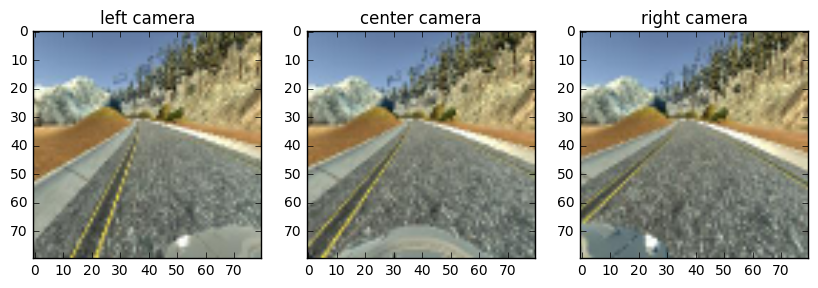

In [5]:
#visualize 3 camera frames
np.random.seed(1024)
pick_index = np.random.randint(len(x_train_c))

plt.figure(figsize=(10,10))

img_c = x_train_c[pick_index]
img_l = x_train_l[pick_index]
img_r = x_train_r[pick_index]

plt.subplot(1,3,1)
plt.title("left camera")
plt.imshow(cv2.cvtColor(img_l, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,2)
plt.title("center camera")
plt.imshow(cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,3)
plt.title("right camera")
plt.imshow(cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB))

plt.show()

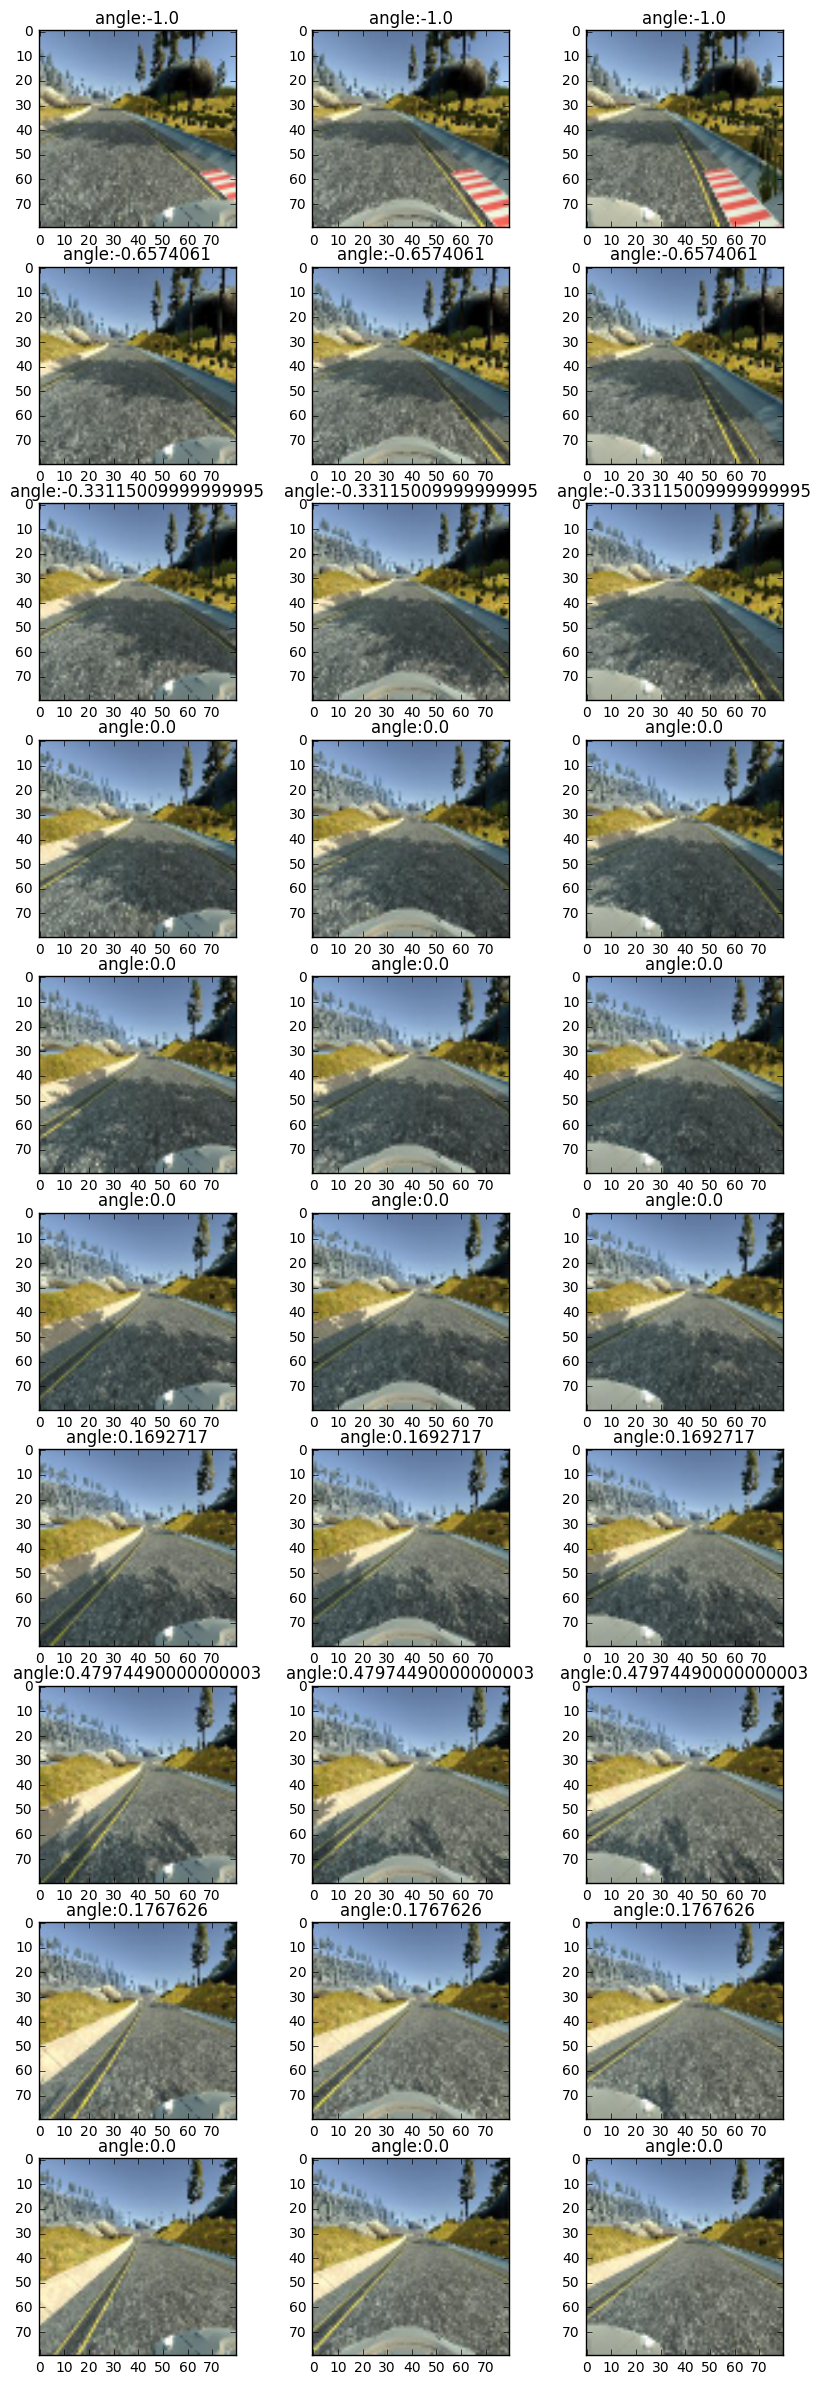

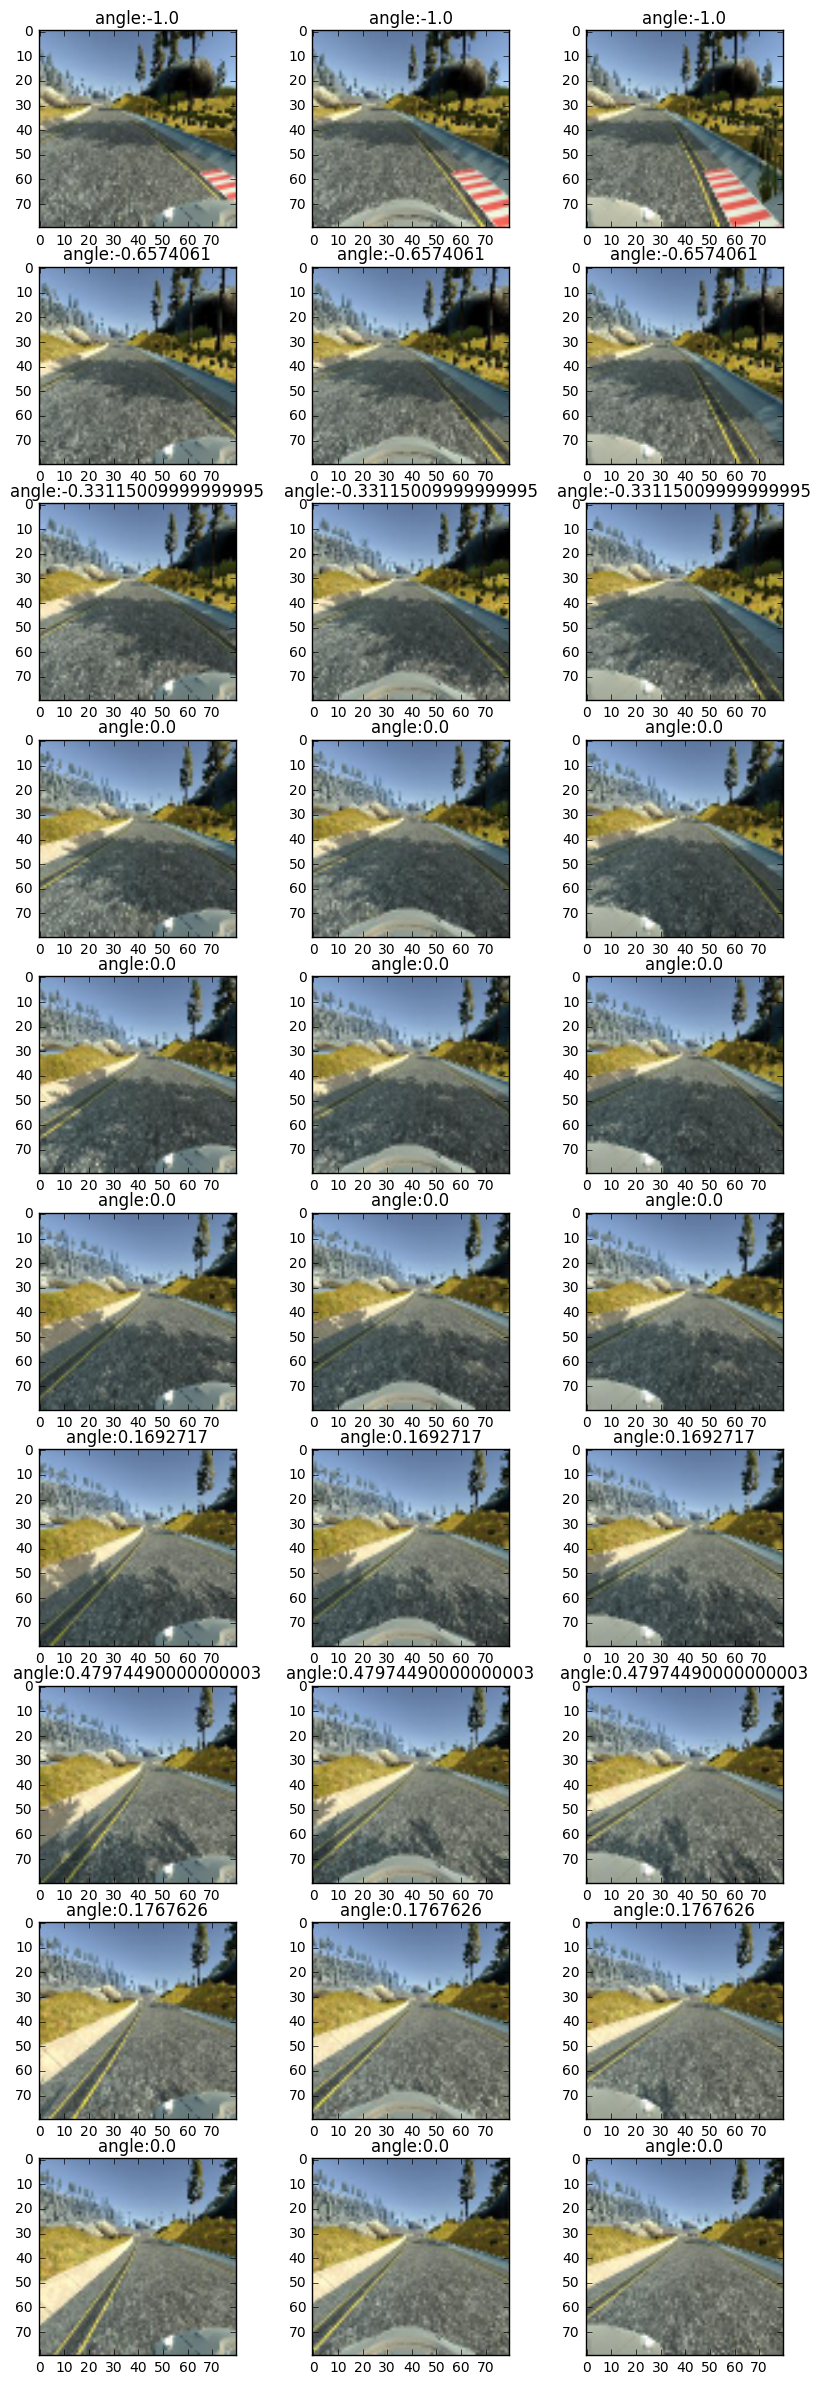

In [6]:
#visualize min/max angle and following 10 frames
min_idx = np.argmin(y_train_c)
show_next_frames(min_idx, [x_train_l, x_train_c, x_train_r], [y_train_l,y_train_c,y_train_r], 10)

max_idx = np.argmax(y_train_c)
show_next_frames(min_idx, [x_train_l, x_train_c, x_train_r], [y_train_l,y_train_c,y_train_r], 10)

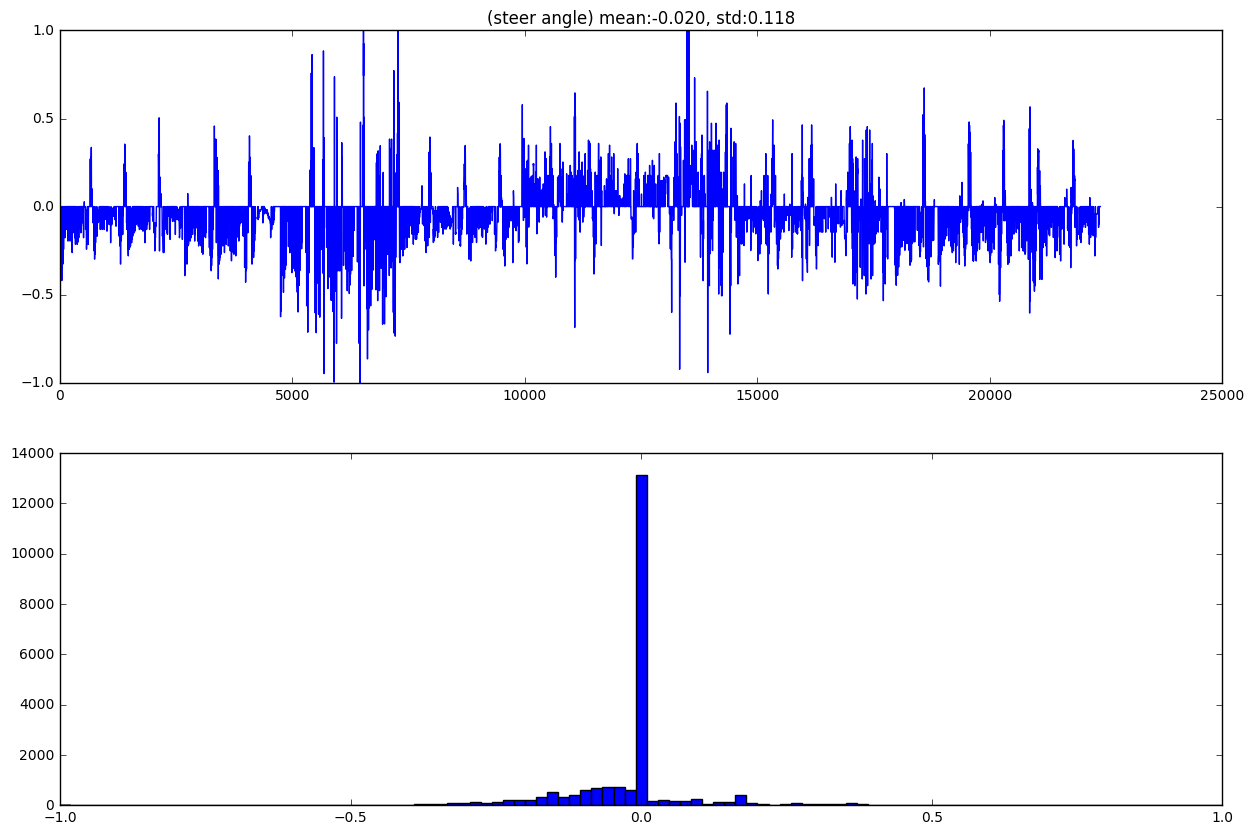

In [7]:
#visualize angle trend chart and histogram
plot_angle_data(y_train_c)

In [8]:
#data augmentation by combining 3 camera frames
x_train, y_train = augment_data_by_side_camera(x_train_l, x_train_c, x_train_r, y_train_c)

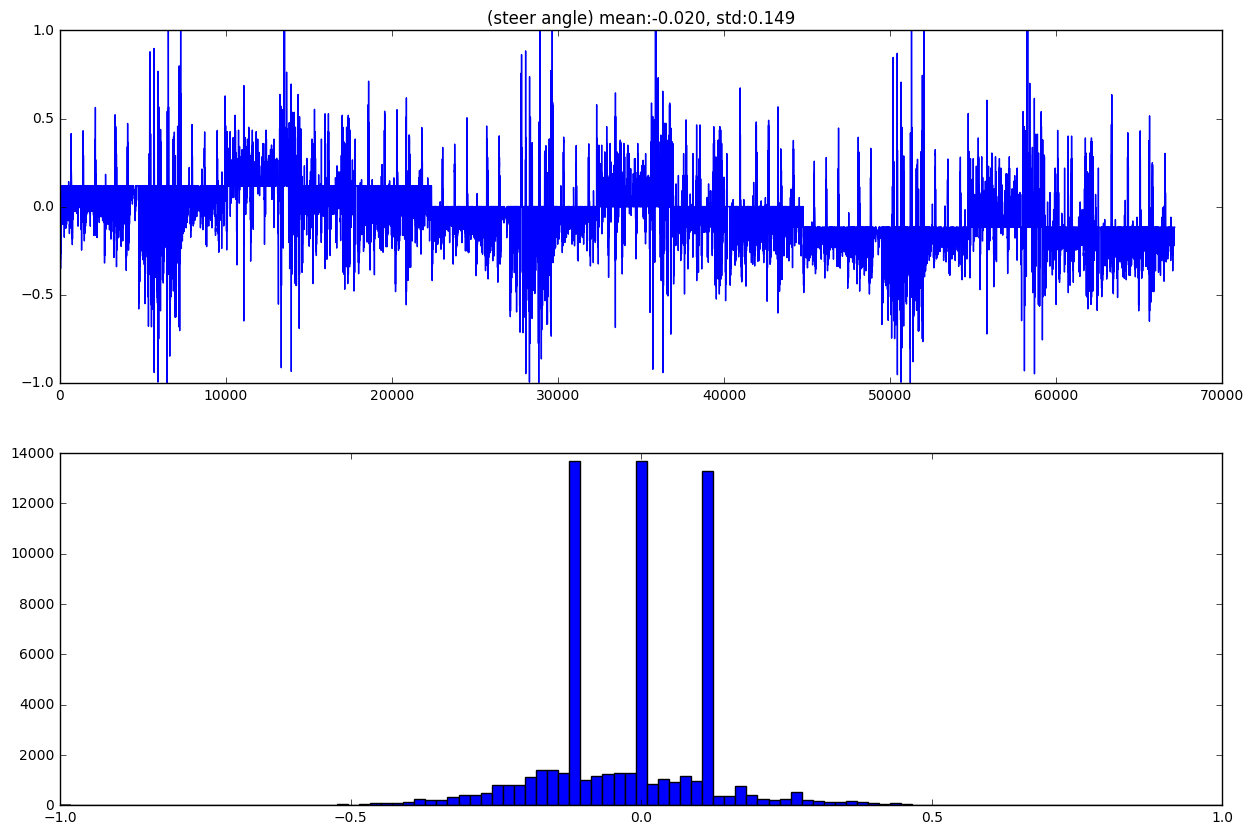

In [9]:
#visualize angle trend chart and histogram
plot_angle_data(y_train)

In [10]:
#data preprocess: append gray channel
x_train_processed = preprocess_insert_gray_channel(x_train)

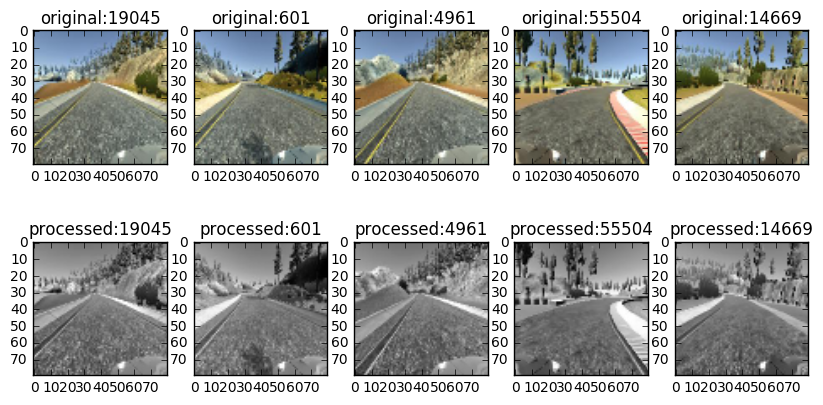

In [11]:
#visualize preprocess data        
plot_processed_data(x_train_processed)

In [12]:
#data augmentation by combining flip
x_train_augmented, y_train_augmented = augment_data_by_flip(x_train_processed, y_train)
print("x_train_augmented shape:", x_train_augmented.shape)
print("y_train_augmented shape:", y_train_augmented.shape)

x_train_augmented shape: (134250, 80, 80, 4)
y_train_augmented shape: (134250,)


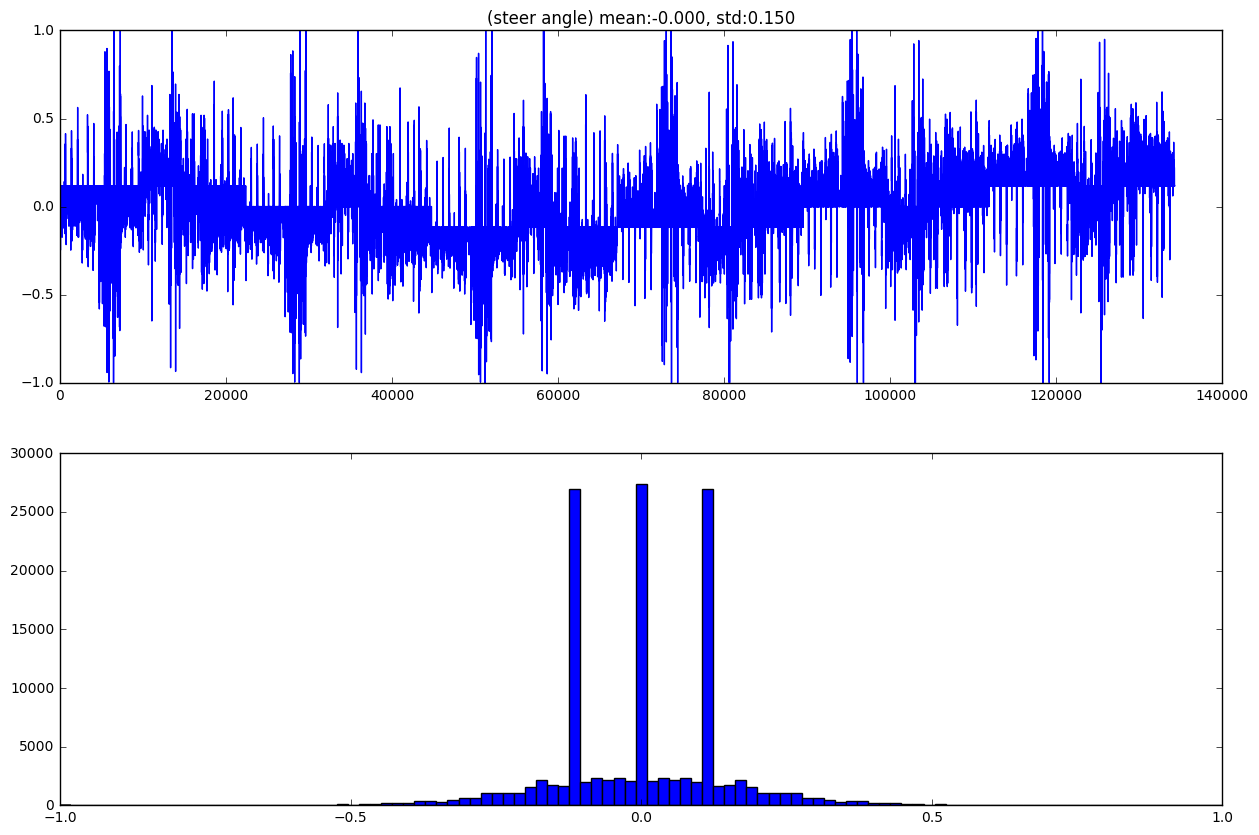

In [13]:
#visualize angle trend chart and histogram
plot_angle_data(y_train_augmented)

In [29]:
dense_net = create_dense_net((height, width, channel+1), 3*4+4, 3, 8, -1, True, 0.5, 0)
json_string = dense_net.to_json()

with open(model_dn_fn + ".json", "w") as json_file:
    json_file.write(json_string)
    from_scratch = False
    result = train(dense_net, model_dn_fn + ".h5", x_train_augmented, y_train_augmented, from_scratch, epoch=30)


Bottleneck DenseNet-BC-16-8 with 0.5 compression created.
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 80, 80, 4)     0                                            
____________________________________________________________________________________________________
initial_conv2D (Convolution2D)   (None, 80, 80, 16)    576         input_5[0][0]                    
____________________________________________________________________________________________________
batchnormalization_61 (BatchNorm (None, 80, 80, 16)    64          initial_conv2D[0][0]             
____________________________________________________________________________________________________
activation_61 (Activation)       (None, 80, 80, 16)    0           batchnormalization_61[0][0]      
_________________________________

dict_keys(['val_loss', 'loss'])


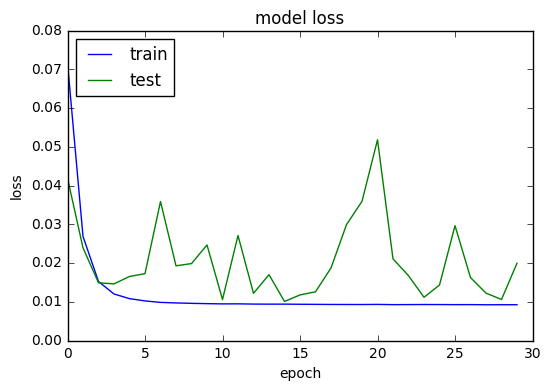

Val MSE: 0.01914381919701148
Val RMSE: 0.13836119107976586


In [34]:
#learning curve
plot_learning_curve(result.history)   

y_pred = result.model.predict(x_train_v)
print( "Val MSE: {}".format(mean_squared_error(y_train_v, y_pred)))
print( "Val RMSE: {}".format(np.sqrt(mean_squared_error(y_train_v, y_pred))))

In [14]:
#train model #2, only use center camera
#data preprocess: append gray channel
x_train_processed = preprocess_insert_gray_channel(x_train_c)

In [15]:
#data augmentation by combining flip
x_train_augmented, y_train_augmented = augment_data_by_flip(x_train_processed, y_train_c)
print("x_train_augmented shape:", x_train_augmented.shape)
print("y_train_augmented shape:", y_train_augmented.shape)

x_train_augmented shape: (44750, 80, 80, 4)
y_train_augmented shape: (44750,)


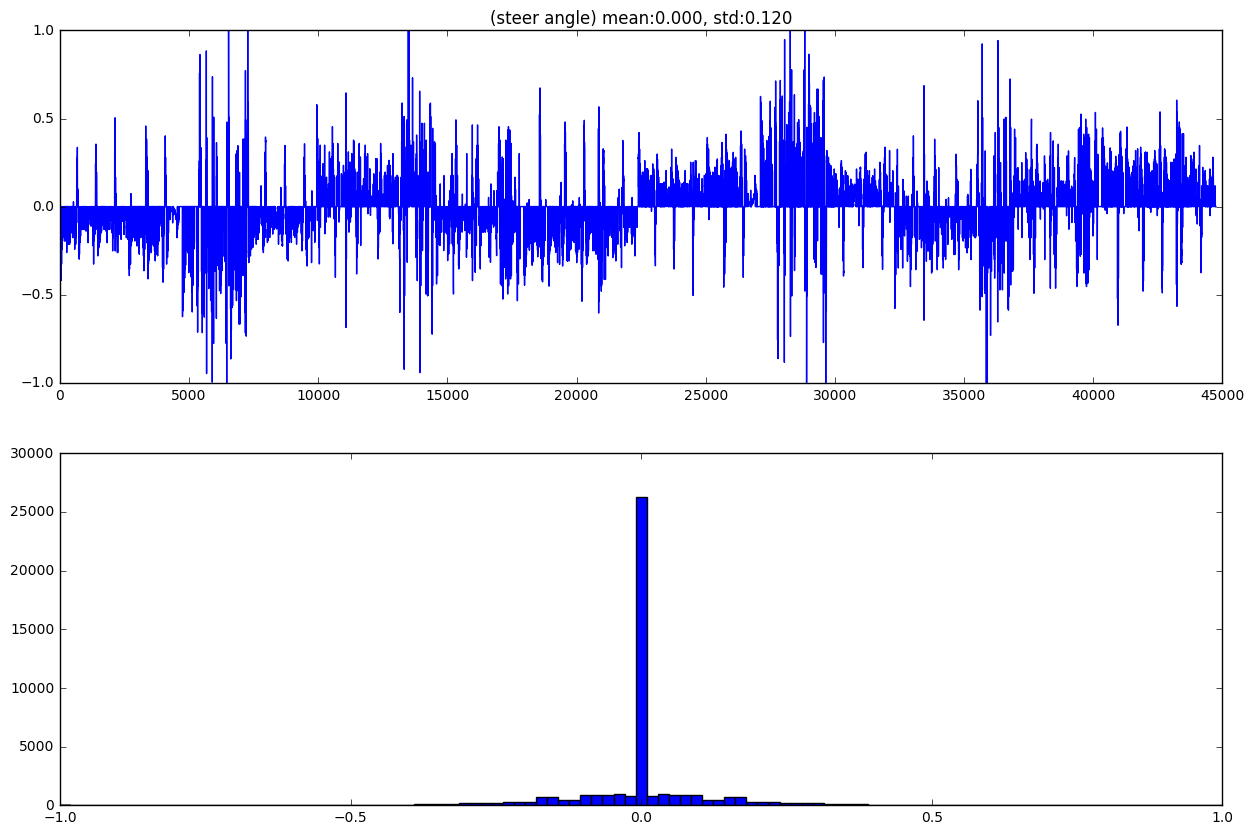

In [17]:
plot_angle_data(y_train_augmented)

In [18]:
#phase 2: Transferring learning (only on center camera)
with open(model_dn_fn + ".json", 'r') as jfile:
    dense_net_final = model_from_json(jfile.read())
    #load model from file
    dense_net_final.load_weights(model_dn_fn+".h5")
    #dn.summary()
    dense_net_final = turn_feature_layers_non_trainable(dense_net_final)
    with open(model_final_fn + ".json", "w") as json_file:
        json_string = dense_net_final.to_json()
        json_file.write(json_string)

    from_scratch = True
    result_final = train(dense_net_final, model_final_fn + ".h5", x_train_augmented, y_train_augmented, from_scratch, 30, 128, 3)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 80, 80, 4)     0                                            
____________________________________________________________________________________________________
initial_conv2D (Convolution2D)   (None, 80, 80, 16)    576         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 80, 80, 16)    64          initial_conv2D[0][0]             
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 80, 80, 16)    0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

dict_keys(['val_loss', 'loss'])


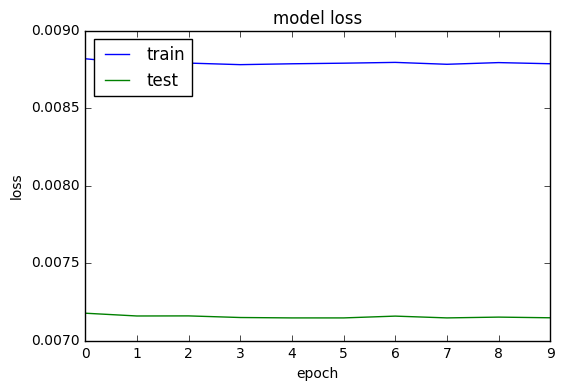

Val MSE: 0.007804003720755605
Val RMSE: 0.08834027236066008


In [23]:
#learning curve
plot_learning_curve(result_final.history)   

y_pred = result_final.model.predict(x_train_augmented)
print( "Val MSE: {}".format(mean_squared_error(y_train_augmented, y_pred)))
print( "Val RMSE: {}".format(np.sqrt(mean_squared_error(y_train_augmented, y_pred))))

## Video

In [1]:
behavior_clone_video = 'content/behavior_clone_video.mp4'
from IPython.display import HTML

In [2]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(behavior_clone_video))